## Rover Project

* Run the simulator in "Training Mode" and record some data.  
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Satisfied with your map?  Move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

In [22]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window
# Relevant imports
from IPython.display import HTML # For video showing in notebook
import cv2 # OpenCV for perspective transform
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
from moviepy.editor import VideoFileClip # needed to edit/save/watch video clips
from moviepy.editor import ImageSequenceClip # needed to edit/save/watch video clips
import pandas as pd # For reading in csv file as a dataframe
# Path to data directory
df = pd.read_csv('../../robot_log.csv')

## Quick Look at the Data
Reading in and displaying a random image from the `test_dataset` folder

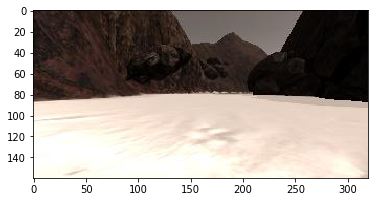

In [17]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
img = mpimg.imread(img_list[idx])
plt.imshow(img)
plt.show()

## Calibration data

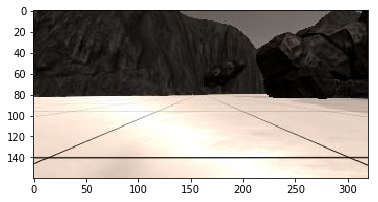

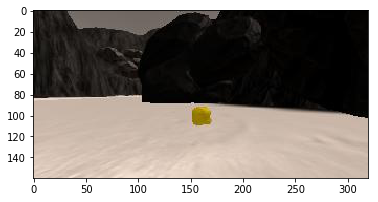

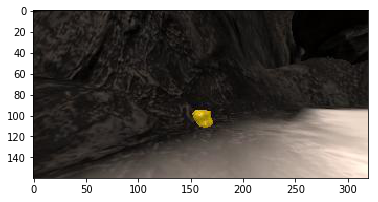

In [3]:
# Getting example images used under calibration of the functions under
grid_img = mpimg.imread('../calibration_images/example_grid1.jpg')
rock_img = mpimg.imread('../calibration_images/example_rock1.jpg')
rock2_img = mpimg.imread('../calibration_images/example_rock2.jpg')

# Plotting images
plt.imshow(grid_img)
plt.show()
plt.imshow(rock_img)
plt.show()
plt.imshow(rock2_img)
plt.show()


## Perspective Transform

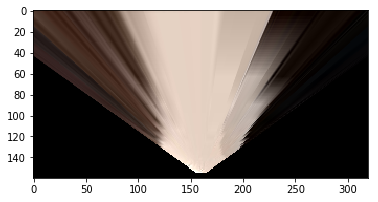

In [18]:

def perspect_transform(img):
    ''' Makes the transform to bird perspective'''
    
    # Defining a tuple containing the image size in (x,y) format for use below
    img_size = (img.shape[1], img.shape[0])
    
    
    # Defining acutal/source cordinates
    src = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    
    # Accounting the fact that the bottom of the picture is not the front of the rover, but a bit in front of it
    bottom_offset = 6
    
    # Value used to find desired cordinates below
    dst_size = 5
    
    # Defining desired/destination coordinates
    dst = np.float32([[img_size[0]/2 - dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - 2*dst_size - bottom_offset], 
                      [img_size[0]/2 - dst_size, img_size[1] - 2*dst_size - bottom_offset],
                      ])
    
    # Gets M, the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Applys M and warps the image to top-down view, here with the same size as the input image
    warped = cv2.warpPerspective(img, M, img_size)

    return warped

warped = perspect_transform(img)
plt.imshow(warped)
plt.show()
#scipy.misc.imsave('../output/warped_example2.jpg', warped)

## Color Thresholding

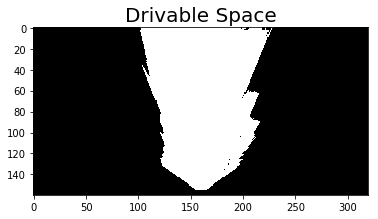

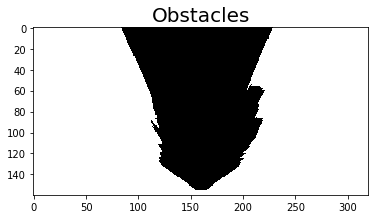

Rock coordinates(x,y) is:  ([], [])


In [19]:

def color_thresh(img, rgb_thresh=(160, 160, 160)):
    ''' Applies a threshold to an input image for mapping drivable space'''
    # An array the same size xy as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    
    # Array containing True where pixel was over the thershold 
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                 & (img[:,:,1] > rgb_thresh[1]) \
                 & (img[:,:,2] > rgb_thresh[2])
    
    # Where the walues are True, set the zero value to 1
    color_select[above_thresh] = 1
    
    # Returning the binary image of drivable space as white 
    return color_select


def obstacles(img, rgb_thresh=(160, 160, 160)): 
    ''' Applies threshold to an input image for mapping obstacles, and finds rocks if there is any'''
    
    ypos = []    # stores rock coordinates corresponding to height of the image
    xpos = []    # stores rock coordinates corresponding to width of the image
    
    obstacles = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    obstacles[below_thresh] = 1
    
    # Making values for HSV, this is our key filtering step for searching after the rock
    ly = np.array([20, 100, 100], dtype = "uint8") # Low value for yellow HSV.
    hy = np.array([30, 255, 255], dtype = "uint8") # Hig value for yellow HSV.
    
    # Generating the HSV image
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV,3)
    
    # Masking the HSV values, so everything that doesn't have the right yellow value will be disregarded
    mask_rock = cv2.inRange(img_hsv, ly, hy)
    
    # Masking the masked rock image back on the original image to get the correct size (channels)
    rock_filter = cv2.bitwise_and(img,img, mask= mask_rock)
    
    # Converting back to RGB colorspace.
    # In this step we have filtered out everything, and only have rock pixels left
    rock = cv2.cvtColor(rock_filter, cv2.COLOR_HSV2RGB,3)
    
    # Value for detecting rocks. 
    # This is very low, because after the HSV conversion, we have filtered out every unnecessary stuff.
    # Converting back doesn't give us the same RGB values as we started with, but values we can use. 
    # So everything that is not black will be part of a rock.
    rock_threshold = (10,10,10) 
    
    # Make a matrix of True and False values, depending on if there is a rock part detected or not
    rock_select = (rock[:,:,0] > rock_threshold[0]) \
                & (rock[:,:,1] > rock_threshold[1]) \
                & (rock[:,:,2] >= rock_threshold[2])
    
    # If there is a rock, do rock detection
    if True in rock_select:

        # Making a image of zeros identical to the original image
        rock_detected = np.zeros_like(img[:,:,0])

        # Making a binary image of where there is detected rock parts
        rock_detected[rock_select] = 1

        # For pipeline-documentation
        #plt.imshow(mask_rock)
        #plt.show()
        #plt.imshow(rock_filter)
        #plt.show()
        #plt.imshow(rock)
        #plt.show()
        #plt.imshow(rock_detected)
        #plt.show()

        for y in range(0, rock_detected.shape[0]):
            for x in range(0, rock_detected.shape[1]):
                if(rock_detected[y, x] == True):
                    xpos = np.append(xpos, x)
                    ypos = np.append(ypos, y)

        # Assuming here that there is only one rock in the image
        ypos = np.int_(np.amax(ypos)) # Because of the warp function it would be wrong taking the mean here
        xpos = np.int_(np.mean(xpos))
    
    rock_coords =(xpos, ypos)
    
    # Return the binary image of obstacles as white, and the rock coordinates (x,y)
    return obstacles, rock_coords

threshed = color_thresh(warped)
obstacles, rock_coords = obstacles(warped)
plt.imshow(threshed, cmap='gray')
plt.title('Drivable Space', fontsize=20)
plt.show()
plt.imshow(obstacles, cmap='gray')
plt.title('Obstacles', fontsize=20)
plt.show()
print('Rock coordinates(x,y) is: ', rock_coords)
#scipy.misc.imsave('../output/Rock_Search_Step4.jpg', rock_detected)

## Coordinate Transformations
Defining functions used to do coordinate transforms

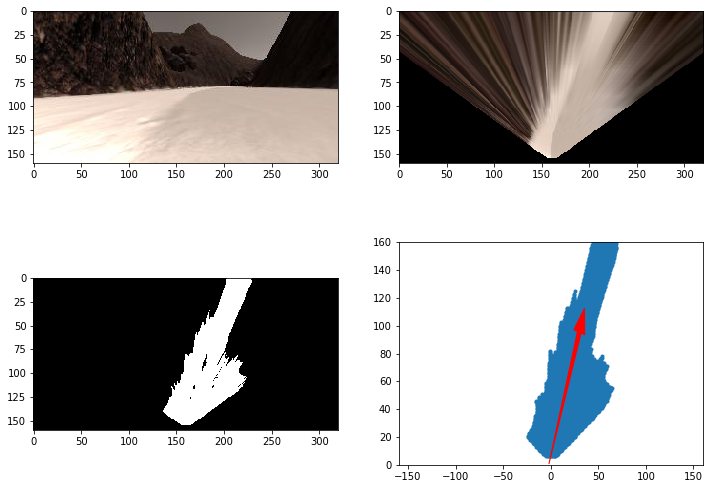

In [6]:

def rover_coords(binary_img, camera_pos):
    ''' Getting coordinates with respect to the rover'''
    ypos, xpos = binary_img.nonzero()

    x_pixel = (xpos - camera_pos[0])
    y_pixel = np.absolute(ypos - camera_pos[1])

    return x_pixel, y_pixel


def to_radial_coords(x_pixel, y_pixel):
    ''' Getting Polar coordinates in rover space'''
    dist  = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(x_pixel, y_pixel)
     
    return dist, angles


def pix_to_world(dist, angles, x_rover, y_rover, yaw_rover):       
    ''' Getting the world space vector of pixel positions'''
    pix_angles = angles + (yaw_rover * np.pi/180) # Converting yaw_rover to rads
    
    # World map of 200x200
    world_size = 200
    
    # Scale factor between rover and world space
    scale = 10
    
    # Using np.clip because some values may be outside the worldmap
    x_pix_world = np.clip(np.int_((x_rover) + (dist/scale * np.sin(pix_angles))), 0, world_size - 1)
    y_pix_world = np.clip(np.int_((y_rover) + (dist/scale * np.cos(pix_angles))), 0, world_size - 1)
    
    return x_pix_world, y_pix_world


# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image2 = mpimg.imread(img_list[idx])
warped = perspect_transform(image2)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
camera_pos = [160,160] # x and y values for where the camera is positioned
xpix, ypix = rover_coords(threshed, camera_pos)
dist, angles = to_radial_coords(xpix, ypix)
mean_angle = np.mean(angles)

# Do some plotting 
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image2)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.xlim(-160, 160)
plt.ylim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.sin(mean_angle)
y_arrow = arrow_length * np.cos(mean_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=12, width=4)



## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [7]:
# This function will be used by moviepy to create an output video
def process_image(img):
    
    # Makes the transform to bird perspective by warping the image
    bird_view = perspect_transform(img)
    
    # Applies a threshold to an input image for mapping drivable space
    threshed = color_thresh(bird_view)
    
    camera_pos = [160,160] # x and y values for where the camera is positioned
    
    # Getting coordinates with respect to the rover
    xpix, ypix = rover_coords(threshed, camera_pos)
    
    # Getting Polar coordinates in rover space
    dist, angles = to_radial_coords(xpix, ypix)

    # Getting navigable positions in world coords by using the global object/variable data, initialised from Databucket() 
    x_world, y_world = pix_to_world(dist, angles, data.xpos[0], data.ypos[0], data.yaw[0])

    # Adding pixel positions to worldmap
    worldmap[y_world, x_world] += 1


    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    # Example
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    cv2.putText(output_image,"Populate this image with your analysis", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    
    # Keep track of the index in Databucket() for remembering which img of mg_list_sorted was the last to be displayed
    data.count += 1 


    return output_image

## Making a video from processed image data

For now the only thing meant for updating and saving with each iteration is `self.worldmap` where you can iteratively build your map, for example, adding navigable terrain pixels to one color channel, obstacles to another, and ground truth to another.

In [10]:

# Creating a list of image pathnames
img_list_sorted = []

for i in df["Path"].tolist():
    if len(i) > 5:
        img_list_sorted.append(i)

# Reading in ground truth map and creating a 3-channel image
# is read in here so you can overplot your results against the ground truth
ground_truth = mpimg.imread('../calibration_images/map_bw.jpg') # A black and white image of a top-down view of the environment
ground_truth_3d = np.dstack((ground_truth*0, ground_truth, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Worldmap is instantiated as 200 x 200 grids corresponding to a 200m x 200m space
# This encompasses the full range of output position values in x and y from the simumator

# Purpose is to be able to access image and map data iteratively while processing images.
# You can gain insight into how various parameters are changing from image to image by saving them to the `Databucket()`
class Databucket():
    def __init__(self):
        self.images = img_list_sorted                             # List over all images sampled
        self.xpos = df["X_Position"].values                       # reading rover position from csv file
        self.ypos = df["Y_Position"].values                       # reading rover position from csv file
        self.yaw = df["Yaw"].values                               # reading rover yaw angle from csv file
        self.count = 0                                            # To iterate over img_list_sorted
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)  # Generating an arbitrarily sized worldmap
        self.ground_truth = ground_truth_3d                       # Ground truth worldmap

# Instantiating a Databucket()
data = Databucket()

# Defining pathname for saving the output video
output = '../output/test_mapping.mp4'

# Doing the video processing
clip = ImageSequenceClip(img_list_sorted, fps=60)
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|████████████████████████████████████████████████████| 292/292 [00:03<00:00, 92.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

Wall time: 3.36 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))